In [1]:
import pandas as pd
import requests
import os
import shutil
import numpy as np


In [33]:
basedir = r'/storage/bee_bumble'
dir_dict = {
    'download': os.path.join(basedir,'Download'),
    'train':  os.path.join(basedir,'train'),
    'test':  os.path.join(basedir,'test','testdata'),
    'valid': os.path.join(basedir,'valid'),
    'train_bee': os.path.join(basedir,'train','biene'),
    'train_bumble': os.path.join(basedir,'train','hummel'),
    'valid_bee': os.path.join(basedir,'valid','biene'),
    'valid_bumble': os.path.join(basedir,'valid','hummel')
           }

In [ ]:
url = 'https://raw.githubusercontent.com/dionhagan/naive-bees/master/train_labels.csv'
urlretrieve(url, os.path.join(dir_dict['download'],'train_labels.csv'))


In [13]:
df = pd.read_csv(os.path.join(dir_dict['download'],'train_labels.csv')).sort_values(['id'])
df = df.reset_index(drop=True)
df.info()
print(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3969 entries, 0 to 3968
Data columns (total 2 columns):
id       3969 non-null int64
genus    3969 non-null float64
dtypes: float64(1), int64(1)
memory usage: 62.1 KB
   id  genus
0   1    1.0
1   2    1.0
2   3    1.0
3   4    0.0
4   5    0.0


In [14]:
print(dir_dict['train_bumble'])
print(len(os.listdir(dir_dict['train_bumble'])))
print(len(os.listdir(dir_dict['train_bee'])))

C:\Users\stjo1\Google Drive\001_Neuronale Netze\101 Buch\213 Kapitel_13\Code\Biene_Hummel\train\hummel
1
1


In [ ]:

from urllib.request import urlretrieve
for index, row in df.iterrows():
    fname = "{:.0f}.jpg".format(row['id'])
    url = 'https://raw.githubusercontent.com/dionhagan/naive-bees/master/images/train/'+fname
    print(url)   
    urlretrieve(url, os.path.join(dir_dict['download'],fname))


In [16]:
df_class = df
df_class['class'] = np.where(df['genus']==1,'bumble','bee')
df_class.head(5)

,id,genus,class
0,1,1.0,bumble
1,2,1.0,bumble
2,3,1.0,bumble
3,4,0.0,bee
4,5,0.0,bee


In [17]:

for index, row in df.iterrows():
    fname = "{:.0f}.jpg".format(row['id'])
    
    classname = row['class']
    if index<2750:
        dest_dir = os.path.join(dir_dict['train_'+classname])
    elif index<3250:
        dest_dir = os.path.join(dir_dict['valid_'+classname])
    else:
        dest_dir = os.path.join(dir_dict['test'])
        
    src = os.path.join(dir_dict['download'],fname)
    dest = os.path.join(dest_dir,classname+fname)
    shutil.copyfile(src, dest)


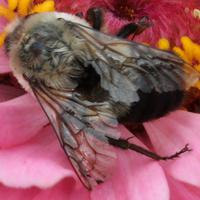

In [30]:
from IPython.display import Image
Image(os.path.join(dir_dict['download'],'9.jpg'))

In [31]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       147584    
__________

In [34]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(        
        dir_dict['train'],      
        target_size=(200, 200),
        batch_size=20,        
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        dir_dict['valid'],
        target_size=(200, 200),
        batch_size=20,
        class_mode='binary')

Found 2750 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

print(class_weights)

In [37]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 383s 4s/step - loss: 0.5229 - acc: 0.7985 - val_loss: 0.5580 - val_acc: 0.7620
Epoch 2/30
100/100 [==============================] - 371s 4s/step - loss: 0.4996 - acc: 0.7980 - val_loss: 0.5088 - val_acc: 0.7620
Epoch 3/30
100/100 [==============================] - 363s 4s/step - loss: 0.4771 - acc: 0.7990 - val_loss: 0.4853 - val_acc: 0.7600
Epoch 4/30
100/100 [==============================] - 348s 3s/step - loss: 0.4544 - acc: 0.8000 - val_loss: 0.4683 - val_acc: 0.7620
Epoch 5/30
100/100 [==============================] - 327s 3s/step - loss: 0.4455 - acc: 0.8065 - val_loss: 0.4704 - val_acc: 0.7620
Epoch 6/30
100/100 [==============================] - 322s 3s/step - loss: 0.4194 - acc: 0.8130 - val_loss: 0.4980 - val_acc: 0.7660
Epoch 7/30
100/100 [==============================] - 306s 3s/step - loss: 0.4345 - acc: 0.8045 - val_loss: 0.4447 - val_acc: 0.7660
Epoch 8/30
100/100 [==============================] - 298s 3s/step - 

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      class_weight = class_weights)

In [ ]:
model.save(os.path.join(basedir,'bee_bumble_1.h5'))

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training Genauigkeit')
plt.plot(epochs, val_acc, 'b', label='Validierung Genauigkeit')
plt.title('Training und Validierung Genauigkeit')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validierung loss')
plt.title('Training und Validierung Loss')
plt.legend()

plt.show()

In [ ]:
validation_generator.reset()
prediction = model.predict_generator(validation_generator, verbose=1)

predicted_class_indices = np.argmax(prediction,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

#decoded = decode_predictions(prediction, top=3)[0]


In [ ]:
filenames=validation_generator.filenames
results = pd.DataFrame({"Filename":filenames,
                       "Predictions":predictions})

In [ ]:
results.head(1000)

In [ ]:
test_generator.reset()